# Créer une carte GeoGuessr

Sur GeoGuessr il existe deux façons de créer des cartes :
* La première est de disposer les points à la main, ce qui est précis mais long et fastidieux. 
* La deuxième est de délimiter une zone à la main et de laisser Geoguessr proposer des points à l'intérieur de la zone. Le problème de cette deuxième méthode est qu'il est également long de délimiter la zone à la main proprement et que les points sont tirés au sort selon les points streetviewés dans la zone. Ce tirage au sort à le défaut de proposer trop souvent les zones denses (en France par exemple, on tombera bien trop souvent à Paris du fait de la densité des routes streetviewés dans la ville).

Pour avoir une carte dans une zone précise avec des points équitablement répartis, nous n'avons donc d'autre choix que de construire la carte à la main. C'est ce qu'on fait plusieurs personnes de la communauté d'AntoineDaniel en placant minutieusement 200 points par départements en France, soit 19200 points.

Le but de ce notebook est de voir dans quelle mesure il est possible de reproduire ce travail de façon automatique.

## Bibliothèques utilisées

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import shapefile
import shapely

from shapely.geometry import Point
from shapely.geometry import shape
from tqdm import tqdm

## Paramètres

La France métropolitaine est entièrement contenue dans la zone située entre les latitudes 41° à 52° et les longitudes -6° à 10°.

Les frontières de la France sont disponibles sur des sites comme gdam.org, notamment sous le un format '.shp'.

Les services streetviews sont utilisables avec les API de Google Cloud, qui demandent une clé.

In [47]:
# Region boundaries
LAT_MIN = 41
LAT_MAX = 52
LON_MIN = -6
LON_MAX = 10

# Number of points on the final maps
N_POINTS = 1000

# Region real boundaries
MAP_SHAPEFILE_PATH = 'gadm36_FRA_0.shp'

# Google API key
with open("GOOGLE_API_KEY.txt","r") as f:
    GOOGLE_API_KEY = f.read()

## 1. Générer un point

Comme première étape, on génère simplement un point dans la grande zone qui englobe la France.

In [4]:
def get_point():
    lat = random.uniform(a=LAT_MIN, b=LAT_MAX)
    lon = random.uniform(a=LON_MIN, b=LON_MAX)
    return lat, lon

get_point()

(43.99966646182513, -5.8607130580358415)

## 2. Vérifier si le point est en France

Pour savoir si le point généré nous intéresse, on vérifie s'il est en France. Pour cela on se base sur les données des frontières de la France. Ces données sont luers grâce à la bibliothèque shapefile.

In [5]:
# Load map boundaries
shapes = shapefile.Reader(MAP_SHAPEFILE_PATH)
boundary = shapes.shapes()[0]

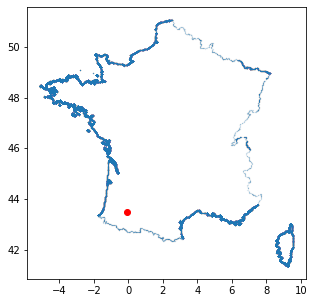

Is the point within boundaries ?


True

In [53]:
# Plot boundaries
plt.figure(figsize=(5,5))
X, Y = np.array(boundary.points).T
plt.plot(X, Y, '.', markersize=0.05)

# Plot a point
lat, lon = get_point()
plt.plot(lon, lat, 'o', color="red")

plt.show()

# Test if point is in boundaries
print("Is the point within boundaries ?")
pt = lon, lat
Point(pt).within(shape(boundary))

On crée donc une fonction pour tester si le point est en France puis on met à jour notre fonction qui donne un point.

In [29]:
def point_is_within(pt):
    lat, lon = pt
    pt = lon, lat
    return Point(pt).within(shape(boundary))

In [30]:
def get_point_within():
    pt = get_point()
    while not(point_is_within(pt)):
        pt = get_point()
    return pt

get_point_within()

(46.82835872983593, 0.5428442819266994)

## 3. Vérifier si le point est streetviewé

Maintenant que nous avons des points en France, il faut savoir s'ils sont streetviewés ou non. Pour cela on fait appel à l'API de Google Streetview. La technique utilisée ici est de demander à Google les informations (metadata) sur la photo que l'on obtient sur Google Streetview pour une certaine géolocalisation. Si cette photo existe, l'information "status" prend la valeur "OK". C'est cela que l'on teste ici puis on pet à jour notre fonction qui donne un point.

Documentation : https://developers.google.com/maps/documentation/streetview/metadata

L'idée vient de ce topic : https://stackoverflow.com/questions/39668776/python-how-to-check-whether-google-street-view-api-returns-no-image-or-the-api

In [31]:
def point_is_streetviewed(pt):
    lat, lon = pt
    url = f"https://maps.googleapis.com/maps/api/streetview/metadata?size=600x300&heading=-45&pitch=42&fov=110&location={lat},{lon}&key={GOOGLE_API_KEY}"
    r = requests.get(url)
    status = r.json()['status']
    return status == "OK"

In [32]:
def get_good_point():
    pt = get_point_within()
    while not(point_is_streetviewed(pt)):
        pt = get_point_within()
    return pt

get_good_point()

(48.58608003221633, 1.5911792053243907)

## 4. Générer toutes les localisations

Geoguessr permet la création de carte en important un fichier .csv, dont le format est le suivant : lat-1, lng-1, ..., lat-n, lng-n. La fonction qui suit utilise N_POINTS fois la fonction qui donne un point intéressant puis les ajoute à une longue liste qui prendra ensuite la forme du .csv demandé par Geoguessr.
(la fonction tqdm permet d'avoir une barre de progression pour savoir combien de bons points ont été trouvés).

In [140]:
def get_N_locations(n_points):
    locations = []
    for i in tqdm(range(n_points)):
        pt = get_good_point()
        lat, lon = pt
        location = str(lat) + "," + str(lon)
        locations.append(location)
    locations = ",".join(locations)
    return locations

get_N_locations(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/it]


'48.43079286400756,2.7655620869210633,44.28513986853329,2.3432728074952838,44.7309736741894,2.7684768153681567,50.73256461156568,2.336110264426548,45.31969160534826,1.5777185448674782,49.1302348856652,3.1544978246150883,47.908158899291124,0.04541670427862243,48.68706973693422,2.290515965822049,47.502546816873625,5.4098621797237705,45.955214384676324,0.9564511041689947'

Pour finir, tout cela est écrit dans un fichier qui sera utilsé par la suite.

In [148]:
%%time
with open(f"France_with_{N_POINTS}_good_points.txt","w") as f:
    f.write(get_N_locations(N_POINTS))

  2%|█▍                                                                            | 18/1000 [03:41<3:21:34, 12.32s/it]


KeyboardInterrupt: 

## 5. Résultat et discussion

### 5.1 Points positifs

Voici une carte de 250 points réalisée avec cette technique : https://www.geoguessr.com/maps/5f2c1f3a94d7db0001bae9ed

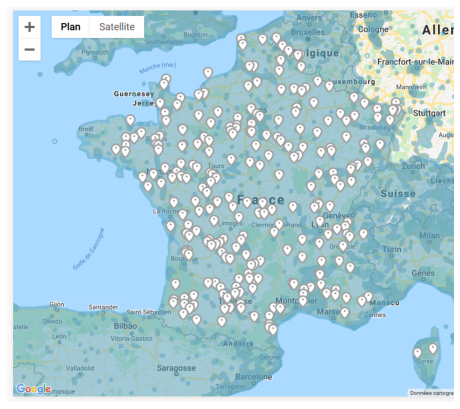

In [43]:
def show_img(path):
    img = plt.imread(path)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
show_img("France_250_points_v1.png")

Ce qui est satisfaisant est de voir que les points se sont répartis partout en France et les regroupements de points sont de simples coincidences. Pas de point à Paris, Lyon, Marseille et de forts regroupements à Périgueux et à Chartres : c'est bien ce que l'on attend d'un tirage aléatoire.

### 5.2 Points à améliorer

Le projet reste pourtant très critiquable :

#### 5.2.1 Lenteur d'exécution
Le programme est très lent. Les 250 points sont sortis en 45 minutes. Ce qui est long est le test qui vérifie si un point est en France ou non. En effet cela est du au grand nombre de points qui délimitent précisément les frontières. Cela pourrait être grandement amélioré en ayant des limites plus grossières à l'intérieur et autour de la France qui permettent un premier test rapide, et le détail serait appelé que quand un point est effectivement proche d'une frontière.

#### 5.2.2 Les points ne sont pas sur les routes !
Google est gentil. Il dit qu'un point est streetviewé même s'il n'est pas exactement mis sur une route. Cela est à la fois un avantage qui nous permet de trouver rapidement des points streetviewés, mais également un gros désavantage car il sera quasiment impossible de faire 25000 points ! En effet Geoguessr nous fait bien démarrer au milieu d'une route même pour un point qui se trouve en réalité dans le jardin d'une maison comme dans cet exemple :

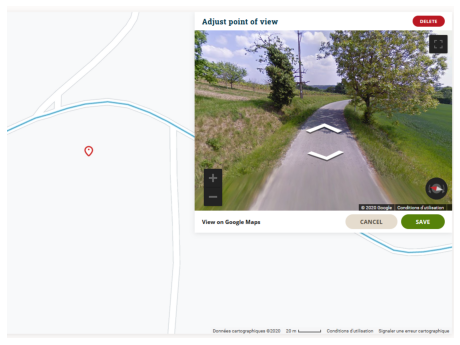

In [44]:
show_img("point_en_dehors_des_routes.png")

Pour changer cela il faudrait remplacer l'étape "Ce point est-il streetviewé?" par "Donne moi les coordonnées du point streetviewé (au milieu d'une route) le plus proche" ! Ce serait l'avancée majeur de ce projet, car après cela la carte serait jouable.

#### 5.2.3 La personnalisation des points

Dans le projet des 19200 points faits à la main, les points sont placés volontairement sur des intersections et jamais dans des impasses pour rendre le jeu plus agréable. C'est un niveau supérieur qui pourrait également être codé mais qui demanderait de faire appel à d'autres services API qui donnent de vraies informations sur le réseau routier. Confronter plusieurs API pourrait aussi donner lieu à d'éventuels problèmes de cohérences entre elles, cela reste à tester.

Enfin, il reste un niveau jamais atteignable par le code : les clins d'oeil. L'aléatoire c'est bien mais les points amusants, les points troll, les fausses pistes, les photos improbables, c'est mieux ! Il n'y a qu'en plaçant à la main que l'on fera les cartes les plus personnalisées.

#### 5.2.4 Conclusion

Ce projet fonctionne, mais il a des limites. Il ne vient pas remplacer la carte de JDay "500 000 lieux en France Métropolitaines" en un clin d'oeil. Les points sont peu précis et générés trop lentement. Seuls les problèmes de frontière et de distribution sont résolus. Il manque la précision et la jouabilité.

Dans son état actuel, il peut servir à pré-construire une carte puisqu'il place le bon nombre de points dans la zone de notre choix. Il y a cependant des progrès possibles qui permettraient de rendre ces cartes réellement jouables et effectivement plus intéressantes que celles crées par l'outil de création de Geoguessr par polygône.